In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action='ignore')

# `Прогнозирование набора цен на электричество с помощью ARIMA.`

In [2]:
class ArimaModel:
    def __init__(self, ts_):
        self.num_of_series = ts_.shape[1]
        self.series_len = ts_.shape[0]
        self.ts = ts_.copy()
        self.best_params = []
        self.forecast_mape = []
        self.forecast_array = []

    def grid_search(self, train_test_ratio=0.95):
        self.best_params = []

        p_range = [6, 8, 10]
        d_range = [0, 1, 2]
        q_range = [0, 1, 2]

        split_point = int(self.series_len * train_test_ratio)

        for i in range(self.num_of_series):
            pdq = []
            mse = float('inf')
            for p in p_range:
                for d in d_range:
                    for q in q_range:
                        model = sm.tsa.statespace.SARIMAX(self.ts.iloc[:split_point, i], order=(p, d, q))
                        model.initialize_approximate_diffuse() # this line
                        res = model.fit()

                        predicted = res.predict(split_point, self.series_len - 1)
                        new_mse = MSE(predicted, self.ts.iloc[split_point:, i])

                        if new_mse < mse:
                            mse = new_mse
                            pdq = [p, d, q]

            self.best_params.append(pdq)

    def forecast(self, split_point):
        self.forecast_array = []
        self.forecast_mape = []

        # split_point = int(self.series_len * train_test_ratio)

        for i in range(self.num_of_series):
            model = sm.tsa.statespace.SARIMAX(self.ts.iloc[:split_point, i], order=(self.best_params[i][0], self.best_params[i][1], self.best_params[i][2]))
            model.initialize_approximate_diffuse() # this line
            res = model.fit()

            predicted = res.predict(split_point, self.series_len - 1)
            mape = MAPE(predicted, self.ts.iloc[split_point:, i].values)
            self.forecast_mape.append(mape)
            self.forecast_array.append(predicted)

        return self.forecast_array

In [3]:
colnames = ['Time'] + [f'Price{i}' for i in range(24)]

df = pd.read_csv('GermanSpotPrice.csv', names=colnames, header=None)
df = df.set_index('Time')
df = df.set_index(df.index - 731582)

df = df.iloc[:2000, :]

for i in range(7, 21):
    del df[f'Price{i}']

for i in range(3):
    df = df.rename(columns={f'Price{21 + i}': f'Price{7 + i}'})

In [4]:
num_of_series = df.shape[1]
ts_len = df.shape[0] # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для прогноза
n_past = L # Ширина окна прогноза

# `Выбор оптимального горизонта прогнозирования`

In [ ]:
MAPE_vs_forecast_horizon = []

model = ArimaModel(df)
_ = model.grid_search();

'for i in range(1, 21):\n    MAPE_array_for_each = []\n    for j in range(5):\n        split_point = ts_len - i\n        forecast = model.forecast(split_point);\n        MAPE_avg = np.array(model.forecast_mape).mean()\n        MAPE_array_for_each.append(MAPE_avg)\n    MAPE_vs_forecast_horizon.append(MAPE_array_for_each)'

In [ ]:
MAPE_vs_forecast_horizon = []

model = ArimaModel(df)
_ = model.grid_search();

for i in range(1, 21):
    MAPE_array_for_each = []
    for j in range(3):
        split_point = ts_len - i
        forecast = model.forecast(split_point);
        MAPE_avg = np.array(model.forecast_mape).mean()
        MAPE_array_for_each.append(MAPE_avg)
    MAPE_vs_forecast_horizon.append(MAPE_array_for_each)

In [ ]:
avg_MAPE_fh = [np.array(arr).mean() for arr in MAPE_vs_forecast_horizon] # усреднение точности по нескольким повторениям одного и того же прогноза
quadratic_dev = [np.array((np.array(arr) - np.array(arr).mean()) ** 2).mean() for arr in MAPE_vs_forecast_horizon] # среднеквадратичное отклонение

In [ ]:
print(quadratic_dev)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.703719777548943e-34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Text(0.5, 1.0, 'Зависимость MAPE от горизонта прогноза ARIMA.')

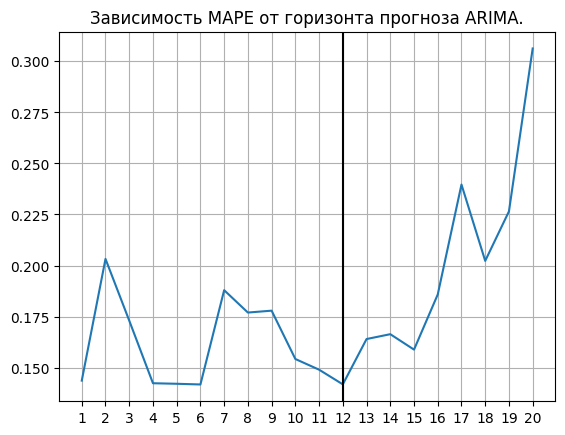

In [ ]:
plt.plot([i for i in range(1, 21)], avg_MAPE_fh)
plt.grid ( True )
plt.xticks([i for i in range(1, 21)])
plt.axvline(x = 12, color='black')
plt.title("Зависимость MAPE от горизонта прогноза ARIMA.")

### `Таким образом, наилучшим горизонтом прогноза является 12 дней.`

# `Выполнение прогноза с наилучшим горизонтом прогноза`

In [ ]:
split_point = ts_len - 12
forecast = model.forecast(split_point);

In [ ]:
print(model.forecast_mape)

[0.07423431159610046, 0.1919099113374466, 0.19311834168935993, 0.21195878996918469, 0.19425665172771858, 0.17978217311624797, 0.18932289759719959, 0.06744845361581481, 0.06799471674362413, 0.04808596042631793]


In [ ]:
def MSE_avg(forecast_ts, test_ts, num_of_series):
    sum_mse = 0
    for i in range(num_of_series):
        ytrue = test_ts.iloc[:, i].values
        yhat = forecast_ts[i]
        mse = MSE(ytrue, yhat)
        sum_mse += mse
    return sum_mse / num_of_series

In [ ]:
mse = MSE_avg(forecast, df.iloc[split_point:, :], num_of_series)

In [ ]:
print(f'MAPE прогноза: {np.array(model.forecast_mape).mean()}')
print(f'MSE прогноза: {mse}')

MAPE прогноза: 0.14181122078190148
MSE прогноза: 76.61534318993823


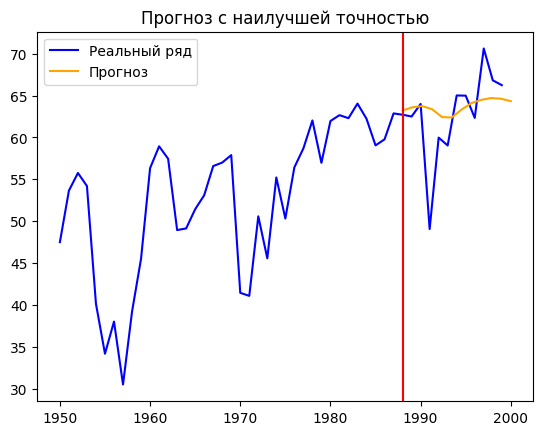

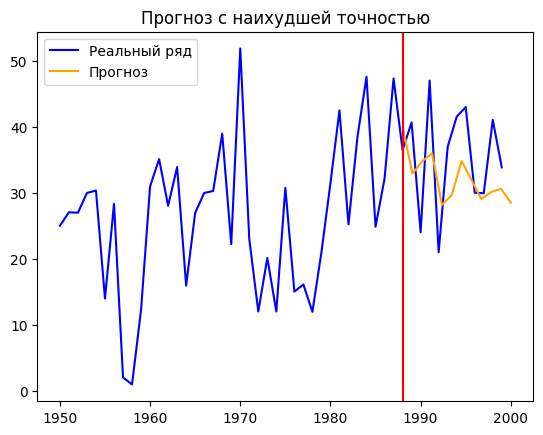

In [ ]:
forecast_len = len(forecast[1])
start_point = model.series_len - forecast_len

plt.plot(model.ts.iloc[1950:, 9], color='b', label="Реальный ряд")
plt.plot(np.linspace(start_point, model.series_len, forecast_len), forecast[9],  color='orange', label="Прогноз")
plt.axvline(x = start_point, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(model.ts.iloc[1950:, 3], color='b', label="Реальный ряд")
plt.plot(np.linspace(start_point, model.series_len, forecast_len), forecast[3],  color='orange', label="Прогноз")
plt.axvline(x = start_point, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

# Временные ряды, функции преобразования в матрицы

In [5]:
def corr_matrix(ts, L, option=3, actual_forecast=False):

    '''
        Данная функция принимает на вход набор временных рядов, ширину окна и возвращает массив X.
        X[i] - матрица корреляции компонент временного ряда в момент времени i + L + 1
    '''

    X = []

    if actual_forecast:
      L1 = L + 1
    else:
      L1 = L

    ts_size = ts.shape[0] # Длина временных рядов
    ts_components = ts.shape[1] # Количество компонент вр.р. в наборе

    for i in range(ts_size - L + 1): # По каждым последовательным L отсчетам времени строим матрицу Сигма
        sigma = np.zeros((ts_components, ts_components)) # Инициализируем нулями
        m = np.zeros((ts_components, 1)) # Вектор матожидания тоже инициализируем нулями

        if option == 2 or option == 3:
            for k in range(ts_components): # Вычисляем вектор матожидания
                sum_ = 0
                for l in range(L):
                    sum_ += ts.iloc[i + l, k] / L
                m[k, 0] = sum_

        if option == 3:
            sqrt_dispercion = [] # Заводим массив, где будут храниться корни из дисперсии для каждого момента времени из [i, i + L - 1]
            for k in range(ts_components): # Рассчитываем вектор корней из дисперсии
                sum_ = 0
                for time in range(L):
                    sum_ += ((ts.iloc[i + time, k] - m[k, 0]) ** 2) / L

                sqrt_dispercion.append(np.sqrt(sum_))

        for j in range(L): # Считаем матрицу Sigma_2
            vector = ts.iloc[i + j, :ts_components].values
            vector = vector.reshape(-1, 1)
            sigma += np.outer(vector - m, (vector - m).T) / L1

        if option == 3:
            for row in range(ts_components): # Делим [row, col] - ый элемент матрицы на соответствующие корни из дисперсии, получаем матрицу корреляции, т.е Sigma_3
                for col in range(ts_components):
                    sigma[row, col] = sigma[row, col] / (sqrt_dispercion[row] * sqrt_dispercion[col])

        X.append(sigma) # Добавляем полученную матрицу в массив входов

    return X

In [6]:
def corr_mtx_to_ts(X, L, num_of_series, option=0):

    '''
        Данная функция получает на вход массив матриц корреляции X
        (X[i] - матрица корреляции компонент временного ряда в момент времени i + L + 1) и ширину окна L.
        Далее массив преобразуется в набор временных рядов, состоящий из n(n - 1) / 2 компонент,
        где каждая компонента - это изменение корреляции между временными рядами исходного набора.
    '''

    corr_data = []
    X_size = len(X)
    for i in range(X_size):
        upper_triangle_indices = np.triu_indices(X[i].shape[0], k=option)
        upper_triangle_elements = X[i][upper_triangle_indices]
        corr_data.append(upper_triangle_elements)
    column_names = []

    for i in range(1, num_of_series + 1):
        for j in range(i + option, num_of_series + 1):
            column_names.append(f'corr({i}, {j})')

    time = np.arange(L - 1, X_size + L - 1)
    corr_ts = pd.DataFrame(corr_data, index=time, columns=column_names)
    return corr_ts

In [7]:
def get_sym_matrix(upper_triangular_elements, option=0):
  idx = 0
  n = int((-1 + np.sqrt(1 + 8 * len(upper_triangular_elements))) / 2) + option
  symm_matrix = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      if i > j:
        symm_matrix[i, j] =  symm_matrix[j, i]
      elif i == j and option == 1:
        symm_matrix[i, j] = 1
      else:
        symm_matrix[i, j] = upper_triangular_elements[idx]
        idx += 1

  return symm_matrix

def get_corr_matrices(corr_ts, option=0):
  forecast_size = corr_ts.shape[0]
  components_size = corr_ts.shape[1]
  matrix_ts = []
  for i in range(forecast_size):
    elements = corr_ts.iloc[i, :].values
    matrix_ts.append(get_sym_matrix(elements, option=option)) # metric

  return matrix_ts

# Реальные данные

In [8]:
num_of_series = df.shape[1]
ts_len = df.shape[0] # длина каждого из временных рядов
L = 10 # количество предыдущих значений, используемых для подсчета Sigma
num_of_corr_series_12 = int(num_of_series * (num_of_series + 1) / 2)
num_of_corr_series_3 = int(num_of_series * (num_of_series - 1) / 2) # Количество временных рядов в наборе
n_past = L # Ширина окна прогноза

In [9]:
X_1 = corr_matrix(df, L, option=1) # Создаем массив матриц корреляции при трех различных подсчетах Sigma
X_2 = corr_matrix(df, L, option=2)
X_3 = corr_matrix(df, L, option=3)

corr_ts_1 = corr_mtx_to_ts(X_1, L, num_of_series) # Получаем соответствующие временные ряды
corr_ts_2 = corr_mtx_to_ts(X_2, L, num_of_series)
corr_ts_3 = corr_mtx_to_ts(X_3, L, num_of_series, option=1)

# `Выбор оптимального горизонта прогноза`

In [12]:
MAPE_vs_forecast_horizon = []

model = ArimaModel(corr_ts_1)
_ = model.grid_search();

In [13]:
series_size = corr_ts_1.shape[0]

In [14]:
for i in range(1, 21):
    split_point = series_size - i
    forecast = model.forecast(split_point);
    MAPE_vs_forecast_horizon.append(np.array(model.forecast_mape).mean())

Text(0.5, 1.0, 'Зависимость MAPE от горизонта прогноза ARIMA при первом способе прогноза Sigma.')

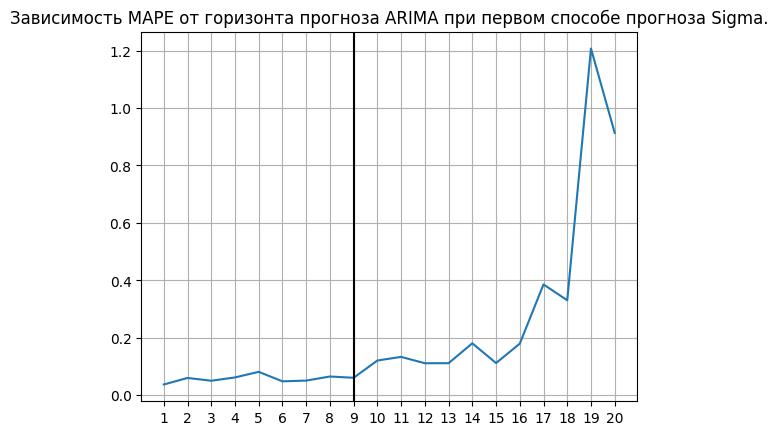

In [18]:
plt.plot([i for i in range(1, 21)], MAPE_vs_forecast_horizon[:])
plt.grid ( True )
plt.xticks([i for i in range(1, 21)])
plt.axvline(x = 9, color='black')
plt.title("Зависимость MAPE от горизонта прогноза ARIMA при первом способе прогноза Sigma.")

# `Выполнение прогноза при первом способе подсчета Σ`  

In [19]:
optimal_horizon = 9

In [20]:
split_point = series_size - optimal_horizon

In [23]:
forecast = model.forecast(split_point)

In [25]:
forecast_np = np.array(forecast)
forecast_np = forecast_np.T
forecast_corr_1 = pd.DataFrame(forecast_np)

forecast_corr_1 = forecast_corr_1.set_index(forecast_corr_1.index + split_point + L - 1)

In [27]:
sum_MAPE = 0
sum_MSE = 0

for i in range(num_of_corr_series_12):
    ytrue = corr_ts_1.iloc[split_point:, i].values
    yhat = forecast_corr_1.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    sum_MAPE += mape
    sum_MSE += int(mse)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

print(f"Среднее MAPE: {sum_MAPE / num_of_corr_series_12}, Среднее MSE: {sum_MSE / num_of_corr_series_12}")

0: MAPE = 0.021749021969585794, MSE = 7905.501465378381
1: MAPE = 0.043445352093022666, MSE = 24566.36426443037
2: MAPE = 0.033909918768374826, MSE = 9587.015373731587
3: MAPE = 0.0291721860526352, MSE = 4562.127331760456
4: MAPE = 0.03581095002695125, MSE = 7990.3160719652205
5: MAPE = 0.05507658203872057, MSE = 23309.196840120785
6: MAPE = 0.044723621079565845, MSE = 21728.97107919007
7: MAPE = 0.021727075770484654, MSE = 13576.120749568518
8: MAPE = 0.026662084277873685, MSE = 16685.465001483673
9: MAPE = 0.02418665752450613, MSE = 10401.303476242523
10: MAPE = 0.12242859923389054, MSE = 106288.7121470925
11: MAPE = 0.07435755312154411, MSE = 27613.23708633564
12: MAPE = 0.09210761495410515, MSE = 35564.508202333185
13: MAPE = 0.044082887734572085, MSE = 9031.54666479829
14: MAPE = 0.06707322830208949, MSE = 22751.577248874073
15: MAPE = 0.06464263036480342, MSE = 34384.93466815861
16: MAPE = 0.02823941410836441, MSE = 10691.816398157403
17: MAPE = 0.07748851004126385, MSE = 107488.

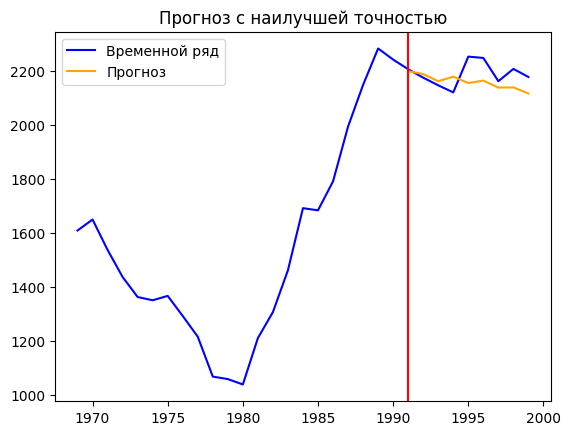

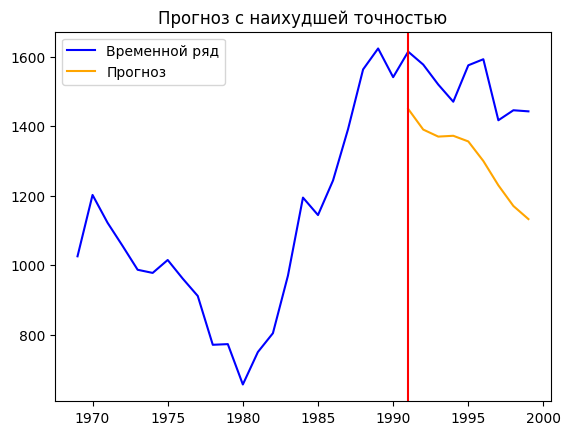

In [28]:
plt.plot(corr_ts_1.iloc[1960:, 33], label="Временной ряд", color='b')
plt.plot(forecast_corr_1.iloc[:, 33], label="Прогноз", color='orange')
plt.axvline(x = split_point + L - 1, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(corr_ts_1.iloc[1960:, 21], label="Временной ряд", color='b')
plt.plot(forecast_corr_1.iloc[:, 21], label="Прогноз", color='orange')
plt.axvline(x = split_point + L - 1, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

# `Восстановление прогноза` $\Sigma_1$

In [29]:
x = np.ones(num_of_series)

In [30]:
matrix_ts = get_corr_matrices(forecast_corr_1)

In [31]:
from scipy.optimize import Bounds, minimize

def optimized_1(x):
    sum = 0
    for i in range(L - 1):
        outer = np.outer(df.iloc[split_point + point + i, :].values, df.iloc[split_point + point + i, :].values)
        sum += outer / L
    sum += np.outer(x, x) / L
    return np.linalg.norm(sum - matrix_ts[point]) ** 2

def optimize_portfolio_1():
    bnds = Bounds(np.zeros_like(x), np.ones_like(x) * np.inf)

    res = minimize(optimized_1, x, method='SLSQP',
                   bounds=bnds)
    return res.x

In [32]:
forecasted_ = []

for point in range(optimal_horizon):
    forecasted_.append(optimize_portfolio_1())

for element in forecasted_:
    element = list(element)

forecasted_ts_x = []

for i in range(num_of_series):
    forecasted_ts_x.append([sublist[i] for sublist in forecasted_])

AVG_MAPE_x = 0
mape_list = []

for i in range(num_of_series):
    mape_ = MAPE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x[i])
    mape_list.append(mape_)
    print(f'MAPE {i} временного ряда: {mape_}')
    AVG_MAPE_x += mape_

print(f'Средняя ошибка MAPE: {AVG_MAPE_x / num_of_series}')

MAPE 0 временного ряда: 0.09787253568352677
MAPE 1 временного ряда: 0.4098273738573024
MAPE 2 временного ряда: 0.4146869956945476
MAPE 3 временного ряда: 0.1622277755399849
MAPE 4 временного ряда: 0.3701542399922606
MAPE 5 временного ряда: 0.5221878042346731
MAPE 6 временного ряда: 0.9704841524628088
MAPE 7 временного ряда: 0.21037313926634887
MAPE 8 временного ряда: 0.2807739514284666
MAPE 9 временного ряда: 0.16735318216610842
Средняя ошибка MAPE: 0.3605941150326028


In [53]:
AVG_MAE_x = 0
mae_list = []
AVG_MSE_x = 0
mse_list = []

for i in range(num_of_series):
    mae_ = MAE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x[i])
    mse_ = MSE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x[i])
    mae_list.append(mae_)
    mse_list.append(mse_)
    print(f'MAE {i} временного ряда: {mae_}, MSE {i} временного ряда: {mse_}')
    AVG_MAE_x += mae_
    AVG_MSE_x += mse_

print(f'Средняя ошибка MAE: {AVG_MAE_x / num_of_series}, MSE: {AVG_MSE_x / num_of_series}')

MAE 0 временного ряда: 6.134124657518508, MSE 0 временного ряда: 53.538972676190525
MAE 1 временного ряда: 20.798724836942824, MSE 1 временного ряда: 537.6734888647566
MAE 2 временного ряда: 17.044226324709534, MSE 2 временного ряда: 362.04073210200943
MAE 3 временного ряда: 5.758809718441512, MSE 3 временного ряда: 51.67276168813636
MAE 4 временного ряда: 12.016656359669062, MSE 4 временного ряда: 189.99902901097585
MAE 5 временного ряда: 19.490740276341572, MSE 5 временного ряда: 442.00345298455323
MAE 6 временного ряда: 20.31232819893579, MSE 6 временного ряда: 507.35943687774187
MAE 7 временного ряда: 14.770195471647002, MSE 7 временного ряда: 252.76734990852117
MAE 8 временного ряда: 19.55956243003281, MSE 8 временного ряда: 412.49792052265974
MAE 9 временного ряда: 10.106945735161121, MSE 9 временного ряда: 126.1530043171105
Средняя ошибка MAE: 14.599231400939974, MSE: 293.5706148952655


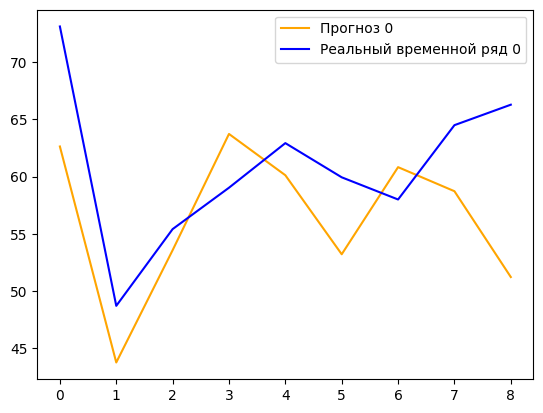

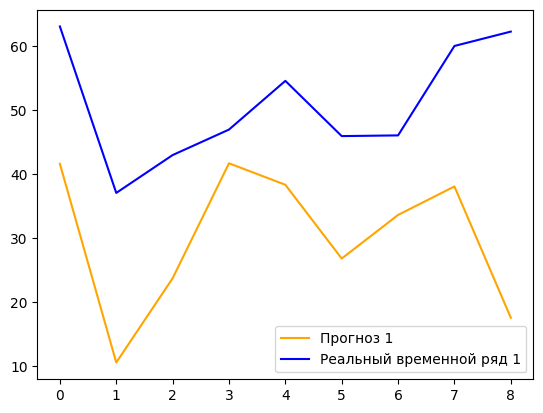

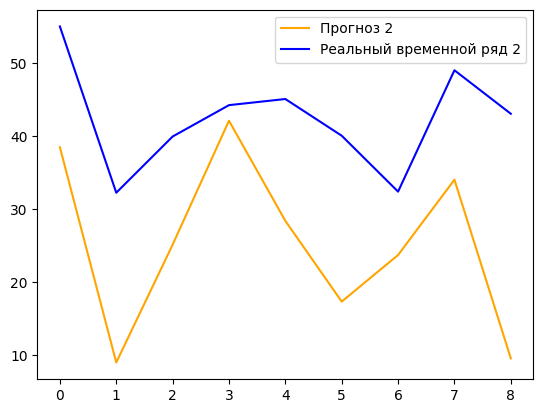

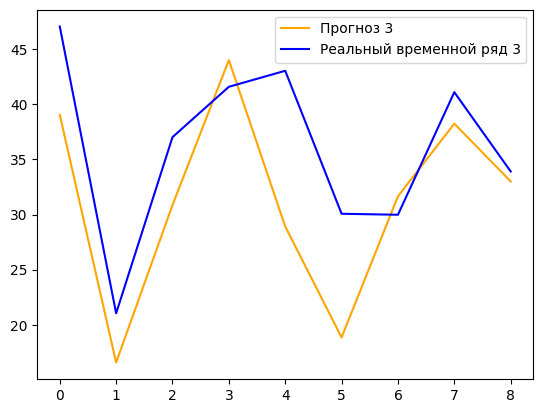

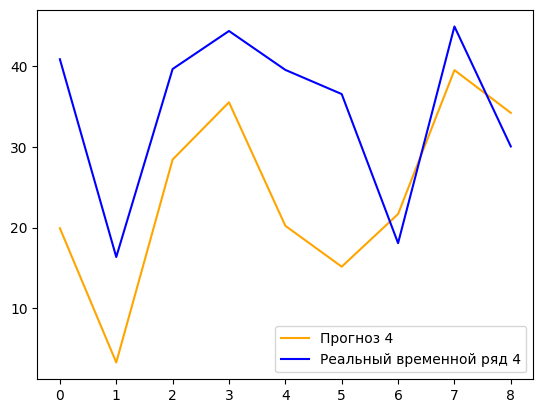

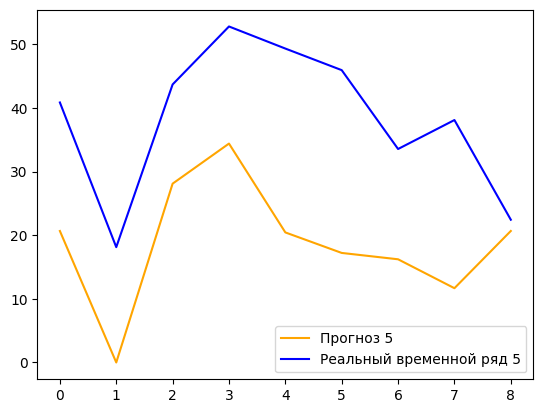

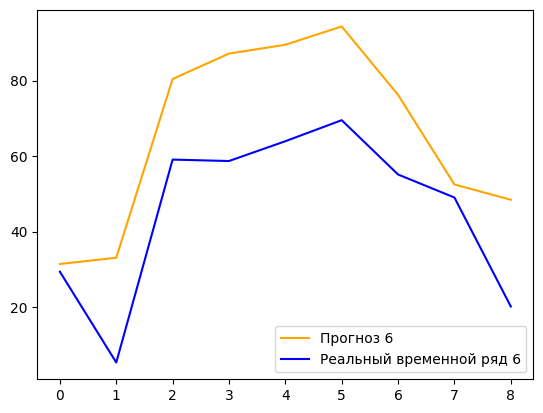

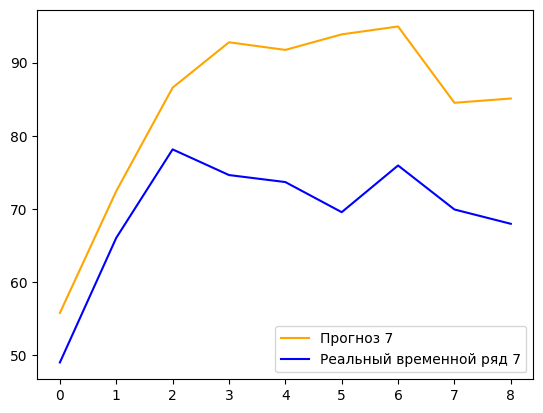

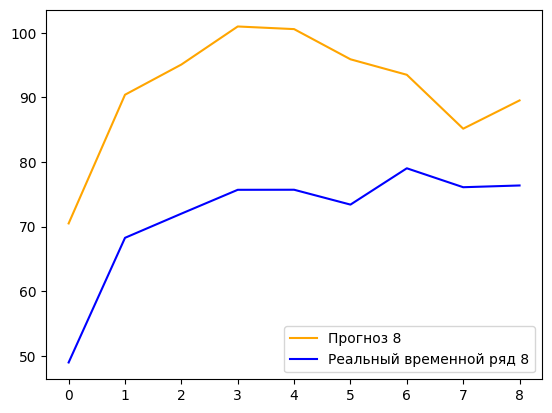

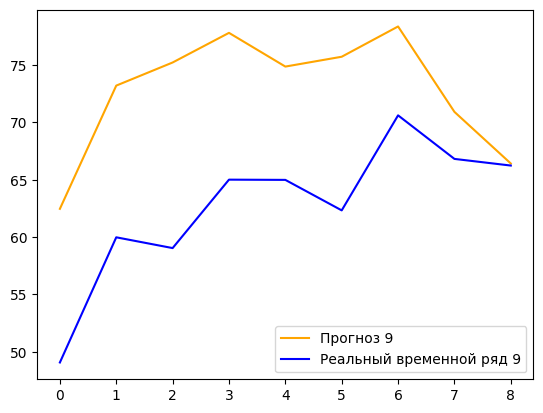

In [33]:
start_point = split_point + L - 1

for i in range(num_of_series):
    plt.plot(forecasted_ts_x[i], label=f'Прогноз {i}', color='orange')
    plt.plot(df.iloc[start_point:, i].values, label=f"Реальный временной ряд {i}", color='b')
    plt.legend()
    plt.show()

# `Выполнение прогноза при втором способе подсчета Σ`  

In [42]:
model_2 = ArimaModel(corr_ts_2)
_ = model_2.grid_search();

In [43]:
forecast_2 = model_2.forecast(split_point)

In [46]:
forecast_np_2 = np.array(forecast_2)
forecast_np_2 = forecast_np_2.T
forecast_corr_2 = pd.DataFrame(forecast_np_2)

forecast_corr_2 = forecast_corr_2.set_index(forecast_corr_2.index + split_point + L - 1)

In [48]:
sum_MAPE = 0
sum_MSE = 0

for i in range(num_of_corr_series_12):
    ytrue = corr_ts_2.iloc[split_point:, i].values
    yhat = forecast_corr_2.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    sum_MAPE += mape
    sum_MSE += int(mse)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

print(f"Среднее MAPE: {sum_MAPE / num_of_corr_series_12}, Среднее MSE: {sum_MSE / num_of_corr_series_12}")

0: MAPE = 0.24235151966170004, MSE = 296.69825645234084
1: MAPE = 0.3216678603192833, MSE = 394.76561932145376
2: MAPE = 0.6310580788742542, MSE = 505.99782382108464
3: MAPE = 0.482813546331303, MSE = 378.54008009811014
4: MAPE = 0.49825454632150445, MSE = 286.55504397910784
5: MAPE = 0.7711940180627496, MSE = 471.86564497545015
6: MAPE = 4.763094595346542, MSE = 1235.4773678489637
7: MAPE = 1.3933048879697152, MSE = 1130.626662213213
8: MAPE = 1.1812587759414688, MSE = 1011.1297933367977
9: MAPE = 1.483775496484704, MSE = 249.32934002566722
10: MAPE = 0.16441490716834614, MSE = 250.9816143188671
11: MAPE = 0.3341896185070911, MSE = 421.25867022605115
12: MAPE = 0.22252156683862895, MSE = 207.5806925491657
13: MAPE = 0.32271731425293804, MSE = 374.49754421106707
14: MAPE = 0.9147689438199479, MSE = 819.1625407687844
15: MAPE = 2.1952525323201093, MSE = 2183.78512380679
16: MAPE = 2.6565944630837457, MSE = 1631.494025515352
17: MAPE = 2.1643514468844924, MSE = 1779.6284786365768
18: MAP

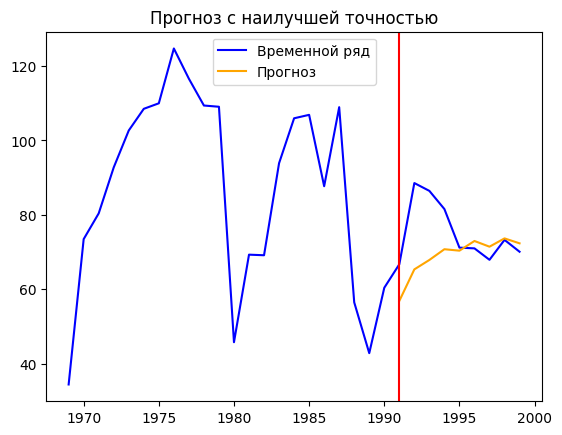

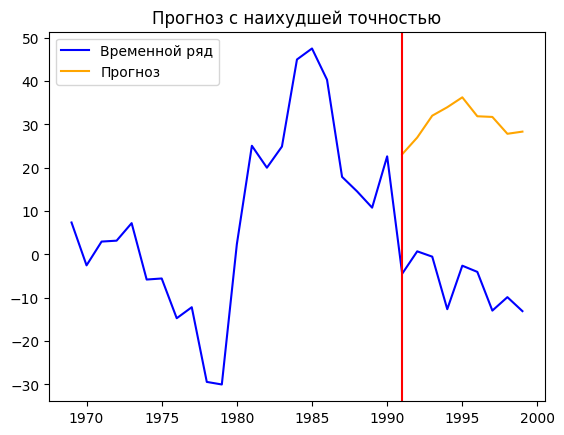

In [49]:
plt.plot(corr_ts_2.iloc[1960:, 28], label="Временной ряд", color='b')
plt.plot(forecast_corr_2.iloc[:, 28], label="Прогноз", color='orange')
plt.axvline(x = split_point + L - 1, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(corr_ts_2.iloc[1960:, 32], label="Временной ряд", color='b')
plt.plot(forecast_corr_2.iloc[:, 32], label="Прогноз", color='orange')
plt.axvline(x = split_point + L - 1, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

# `Восстановление прогноза` $\Sigma_2$

In [50]:
x = np.ones(num_of_series)

matrix_ts_2 = get_corr_matrices(forecast_corr_2)

In [51]:
from scipy.optimize import Bounds, minimize

def optimized_2(x):
    m = np.zeros((1, num_of_series))
    for k in range(num_of_series): # Вычисляем вектор матожидания
        sum_ = 0
        for l in range(L - 1):
            sum_ += df.iloc[split_point + point + l, k] / L
        sum_ += x[k] / L
        m[0, k] = sum_
    sum = 0
    for i in range(L - 1):
        outer = np.outer(df.iloc[split_point + point + i, :].values - m, df.iloc[split_point + point + i, :].values - m)
        sum += outer / L
    sum += np.outer(x - m, x - m) / L
    return np.linalg.norm(sum - matrix_ts_2[point]) ** 2

def optimize_portfolio_2():
    bnds = Bounds(np.zeros_like(x), np.ones_like(x) * np.inf)

    res = minimize(optimized_2, x, method='SLSQP',
                   bounds=bnds)
    return res.x

In [52]:
forecasted_2 = []

for point in range(optimal_horizon):
    forecasted_2.append(optimize_portfolio_2())

for element in forecasted_2:
    element = list(element)

forecasted_ts_x_2 = []

for i in range(num_of_series):
    forecasted_ts_x_2.append([sublist[i] for sublist in forecasted_2])

AVG_MAPE_x_2 = 0
mape_list_2 = []

for i in range(num_of_series):
    mape_ = MAPE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x_2[i])
    mape_list_2.append(mape_)
    print(f'MAPE {i} временного ряда: {mape_}')
    AVG_MAPE_x_2 += mape_

print(f'Средняя ошибка MAPE: {AVG_MAPE_x_2 / num_of_series}')

MAPE 0 временного ряда: 0.19733317501539346
MAPE 1 временного ряда: 0.308946067657699
MAPE 2 временного ряда: 0.444315938065354
MAPE 3 временного ряда: 0.37108964357614366
MAPE 4 временного ряда: 0.33069936212466505
MAPE 5 временного ряда: 0.19065951193326028
MAPE 6 временного ряда: 0.6232935033643333
MAPE 7 временного ряда: 0.18106384789126323
MAPE 8 временного ряда: 0.2284928236833029
MAPE 9 временного ряда: 0.13779799205827037
Средняя ошибка MAPE: 0.3013691865369686


In [54]:
AVG_MAE_x_2 = 0
mae_list_2 = []
AVG_MSE_x_2 = 0
mse_list_2 = []

for i in range(num_of_series):
    mae_ = MAE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x_2[i])
    mse_ = MSE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x_2[i])
    mae_list_2.append(mae_)
    mse_list_2.append(mse_)
    print(f'MAE {i} временного ряда: {mae_}, MSE {i} временного ряда: {mse_}')
    AVG_MAE_x_2 += mae_
    AVG_MSE_x_2 += mse_

print(f'Средняя ошибка MAE: {AVG_MAE_x_2 / num_of_series}, MSE: {AVG_MSE_x_2 / num_of_series}')

MAE 0 временного ряда: 12.424239399840125, MSE 0 временного ряда: 197.7511821995164
MAE 1 временного ряда: 16.689779299938127, MSE 1 временного ряда: 385.8113012645177
MAE 2 временного ряда: 19.120226821595693, MSE 2 временного ряда: 470.7904019401932
MAE 3 временного ряда: 13.892907494120479, MSE 3 временного ряда: 238.7868479532541
MAE 4 временного ряда: 10.650068276931128, MSE 4 временного ряда: 158.65647595631995
MAE 5 временного ряда: 6.833710663489172, MSE 5 временного ряда: 63.78300907050066
MAE 6 временного ряда: 11.661476131930154, MSE 6 временного ряда: 171.6678386532967
MAE 7 временного ряда: 12.191633707350523, MSE 7 временного ряда: 171.82648617127523
MAE 8 временного ряда: 15.993727897680072, MSE 8 временного ряда: 301.9832811882981
MAE 9 временного ряда: 8.685335454164012, MSE 9 временного ряда: 93.08161716790646
Средняя ошибка MAE: 12.814310514703948, MSE: 225.41384415650788


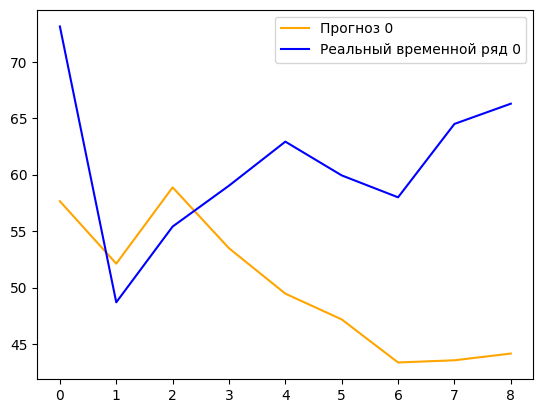

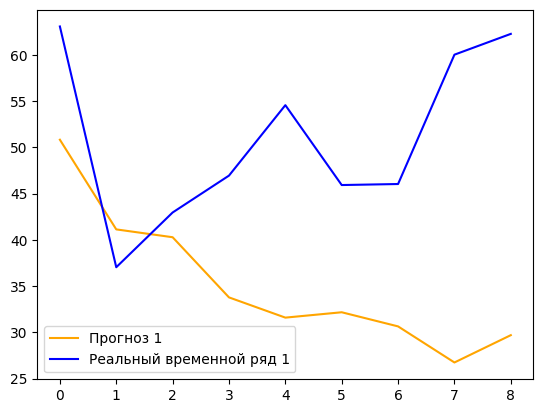

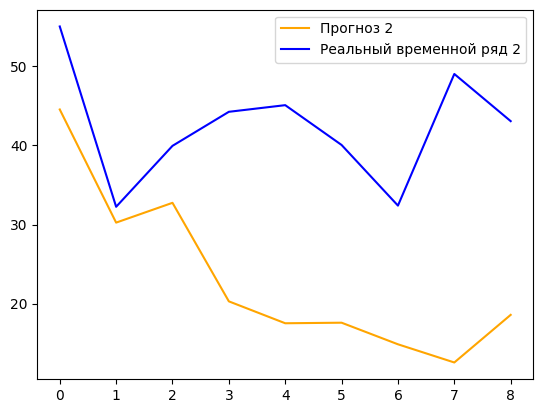

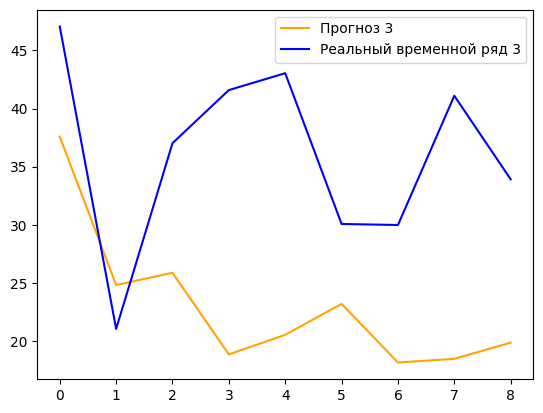

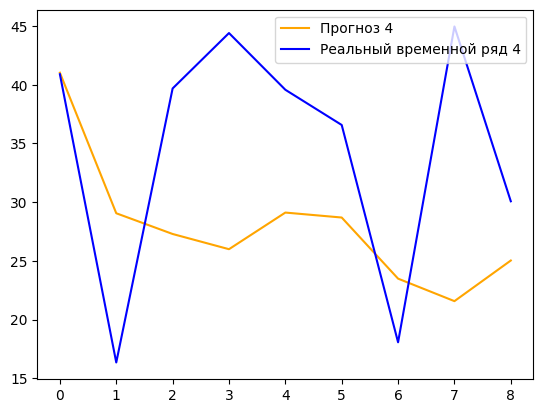

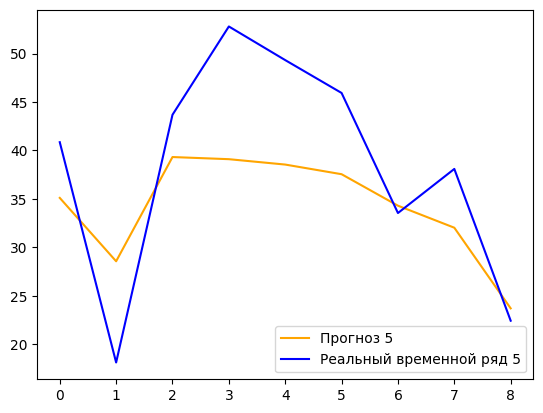

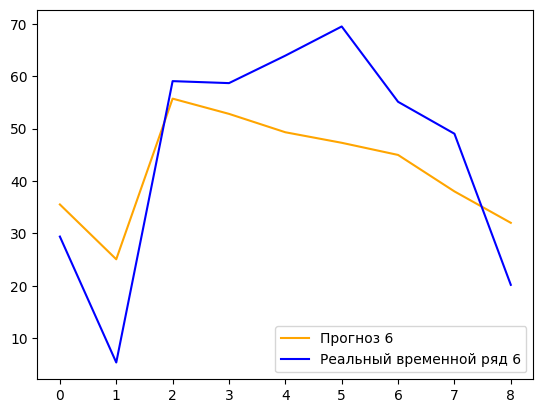

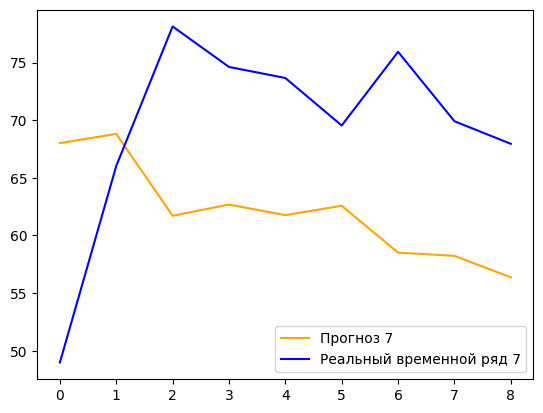

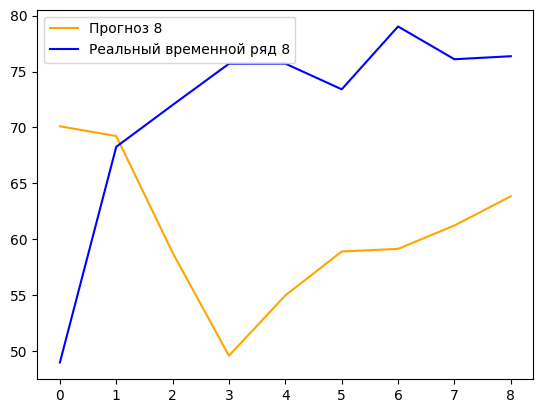

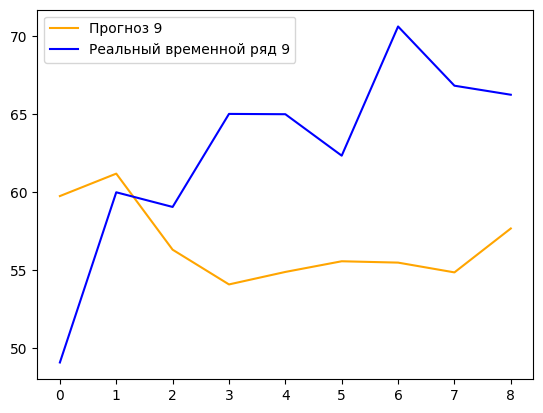

In [55]:
start_point = split_point + L - 1

for i in range(num_of_series):
    plt.plot(forecasted_ts_x_2[i], label=f'Прогноз {i}', color='orange')
    plt.plot(df.iloc[start_point:, i].values, label=f"Реальный временной ряд {i}", color='b')
    plt.legend()
    plt.show()

# `Выполнение прогноза при третьем способе подсчета Σ`  

In [56]:
model_3 = ArimaModel(corr_ts_3)
_ = model_3.grid_search();

In [57]:
forecast_3 = model_3.forecast(split_point)

In [59]:
forecast_np_3 = np.array(forecast_3)
forecast_np_3 = forecast_np_3.T
forecast_corr_3 = pd.DataFrame(forecast_np_3)

forecast_corr_3 = forecast_corr_3.set_index(forecast_corr_3.index + split_point + L - 1)

In [62]:
sum_MAPE = 0
sum_MSE = 0

for i in range(num_of_corr_series_3):
    ytrue = corr_ts_3.iloc[split_point:, i].values
    yhat = forecast_corr_3.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    sum_MAPE += mape
    sum_MSE += mse
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

print(f"Среднее MAPE: {sum_MAPE / num_of_corr_series_3}, Среднее MSE: {sum_MSE / num_of_corr_series_3}")

0: MAPE = 0.2094832784694515, MSE = 0.02776499820138538
1: MAPE = 0.13006845837715053, MSE = 0.00986142843505556
2: MAPE = 0.0935944720616109, MSE = 0.004426607663721524
3: MAPE = 0.11802032791848552, MSE = 0.004730146294938929
4: MAPE = 0.3898123104996755, MSE = 0.025560862878095766
5: MAPE = 5.334148510310732, MSE = 0.041696826887175825
6: MAPE = 1.7884352166597044, MSE = 0.5924190040612162
7: MAPE = 1.1274872928266335, MSE = 0.3015566978542816
8: MAPE = 2.199035538485708, MSE = 0.5526085757961297
9: MAPE = 0.04272428620897749, MSE = 0.002048481424752042
10: MAPE = 0.06419788333916818, MSE = 0.004515961064704301
11: MAPE = 0.2526615796820025, MSE = 0.03705196004973543
12: MAPE = 0.6888614645796631, MSE = 0.04908376149875623
13: MAPE = 2.506866772693064, MSE = 0.08904863865771781
14: MAPE = 3.603798584851577, MSE = 0.5186099950236361
15: MAPE = 2.36328899997985, MSE = 0.4259898249503264
16: MAPE = 1.9136604881140735, MSE = 0.35260162205274564
17: MAPE = 0.08075841560382883, MSE = 0.00

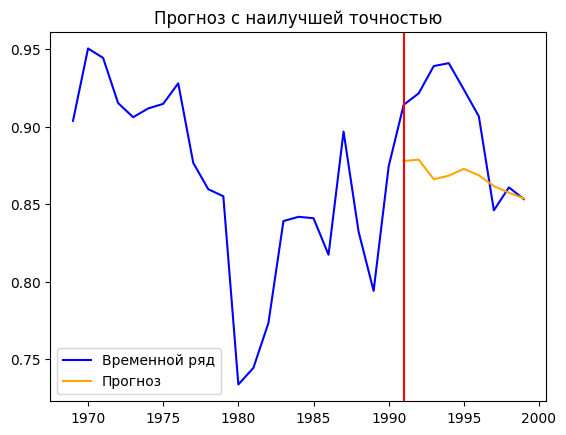

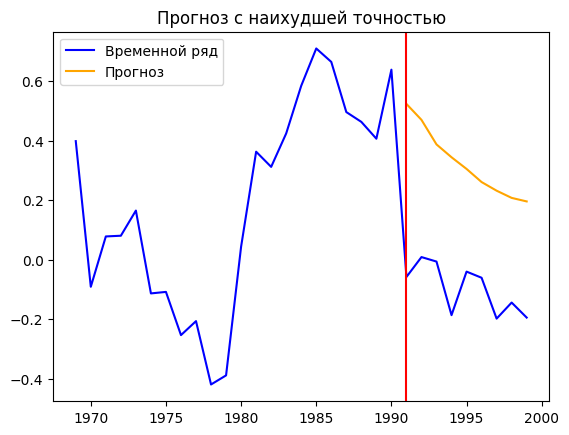

In [63]:
plt.plot(corr_ts_3.iloc[1960:, 24], label="Временной ряд", color='b')
plt.plot(forecast_corr_3.iloc[:, 24], label="Прогноз", color='orange')
plt.axvline(x = split_point + L - 1, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(corr_ts_3.iloc[1960:, 28], label="Временной ряд", color='b')
plt.plot(forecast_corr_3.iloc[:, 28], label="Прогноз", color='orange')
plt.axvline(x = split_point + L - 1, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

# `Восстановление прогноза` $\Sigma_3$

In [64]:
matrix_ts_3 = get_corr_matrices(forecast_corr_3, option=1)

In [65]:
from scipy.optimize import Bounds, minimize

def optimized_3(x):
    m = np.zeros((1, num_of_series))
    for k in range(num_of_series): # Вычисляем вектор матожидания
        sum_ = 0
        for l in range(L - 1):
            sum_ += df.iloc[split_point + point + l, k] / L
        sum_ += x[k] / L
        m[0, k] = sum_

    sqrt_dispercion = [] # Заводим массив, где будут храниться корни из дисперсии для каждого момента времени из [i, i + L - 1]
    for k in range(num_of_series): # Рассчитываем вектор корней из дисперсии
        sum_ = 0
        for time in range(L - 1):
            sum_ += ((df.iloc[split_point + point + time, k] - m[0, k]) ** 2) / L
        sum_ += ((x[k] - m[0, k]) ** 2) / L

        sqrt_dispercion.append(np.sqrt(sum_))

    sum = 0
    for i in range(L - 1):
        outer = np.outer(df.iloc[split_point + point + i, :].values - m, df.iloc[split_point + point + i, :].values - m)
        sum += outer / L
    sum += np.outer(x - m, x - m) / L

    for row in range(num_of_series): # Делим [row, col] - ый элемент матрицы на соответствующие корни из дисперсии, получаем матрицу корреляции, т.е Sigma_3
        for col in range(num_of_series):
            sum[row, col] = sum[row, col] / (sqrt_dispercion[row] * sqrt_dispercion[col])

    return np.linalg.norm(sum - matrix_ts_3[point]) ** 2

def optimize_portfolio_3():
    bnds = Bounds(np.zeros_like(x), np.ones_like(x) * np.inf)

    res = minimize(optimized_3, x, method='SLSQP',
                   bounds=bnds)
    return res.x

In [66]:
forecasted_3 = []

for point in range(optimal_horizon):
    forecasted_3.append(optimize_portfolio_3())

for element in forecasted_3:
    element = list(element)

forecasted_ts_x_3 = []

for i in range(num_of_series):
    forecasted_ts_x_3.append([sublist[i] for sublist in forecasted_3])

AVG_MAPE_x_3 = 0
mape_list_3 = []

for i in range(num_of_series):
    mape_ = MAPE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x_3[i])
    mape_list_3.append(mape_)
    print(f'MAPE {i} временного ряда: {mape_}')
    AVG_MAPE_x_3 += mape_

print(f'Средняя ошибка MAPE: {AVG_MAPE_x_3 / num_of_series}')

MAPE 0 временного ряда: 0.2899435857523789
MAPE 1 временного ряда: 0.479436488361654
MAPE 2 временного ряда: 0.4661792561920919
MAPE 3 временного ряда: 0.36393513059932203
MAPE 4 временного ряда: 0.5210196905363743
MAPE 5 временного ряда: 0.4155654704558187
MAPE 6 временного ряда: 0.784109737872344
MAPE 7 временного ряда: 0.629338656415144
MAPE 8 временного ряда: 0.3453260847016374
MAPE 9 временного ряда: 0.7250123823350305
Средняя ошибка MAPE: 0.5019866483221797


In [67]:
AVG_MAE_x_3 = 0
mae_list_3 = []
AVG_MSE_x_3 = 0
mse_list_3 = []

for i in range(num_of_series):
    mae_ = MAE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x_3[i])
    mse_ = MSE(df.iloc[split_point + L - 1:, i].values, forecasted_ts_x_3[i])
    mae_list_3.append(mae_)
    mse_list_3.append(mse_)
    print(f'MAE {i} временного ряда: {mae_}, MSE {i} временного ряда: {mse_}')
    AVG_MAE_x_3 += mae_
    AVG_MSE_x_3 += mse_

print(f'Средняя ошибка MAE: {AVG_MAE_x_3 / num_of_series}, MSE: {AVG_MSE_x_3 / num_of_series}')

MAE 0 временного ряда: 17.631605875101215, MSE 0 временного ряда: 328.7746336181971
MAE 1 временного ряда: 24.757311367487322, MSE 1 временного ряда: 733.1508162771134
MAE 2 временного ряда: 20.413467164225665, MSE 2 временного ряда: 541.4992843266385
MAE 3 временного ряда: 14.514299449572771, MSE 3 временного ряда: 319.1670749060455
MAE 4 временного ряда: 18.676095586234528, MSE 4 временного ряда: 458.7321294951273
MAE 5 временного ряда: 16.376810666559106, MSE 5 временного ряда: 313.8932733619856
MAE 6 временного ряда: 23.296409144088333, MSE 6 временного ряда: 680.7881742496893
MAE 7 временного ряда: 44.074639971169766, MSE 7 временного ряда: 2321.6037687902285
MAE 8 временного ряда: 24.51868846390068, MSE 8 временного ряда: 997.0708549645956
MAE 9 временного ряда: 45.224240607674545, MSE 9 временного ряда: 2490.2803341698364
Средняя ошибка MAE: 24.948356829601394, MSE: 918.4960344159457


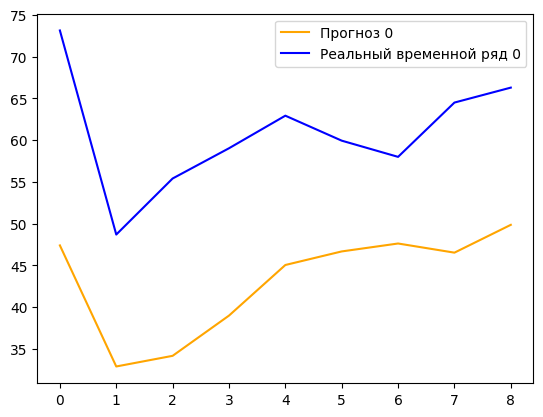

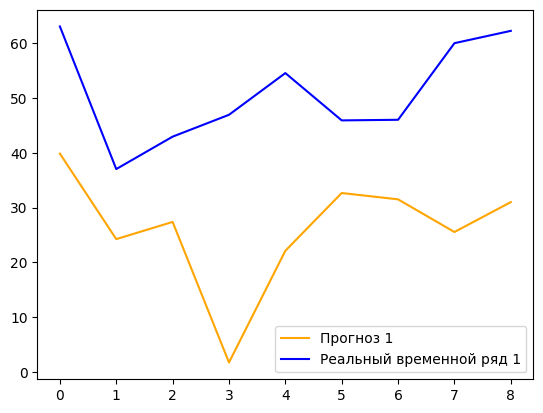

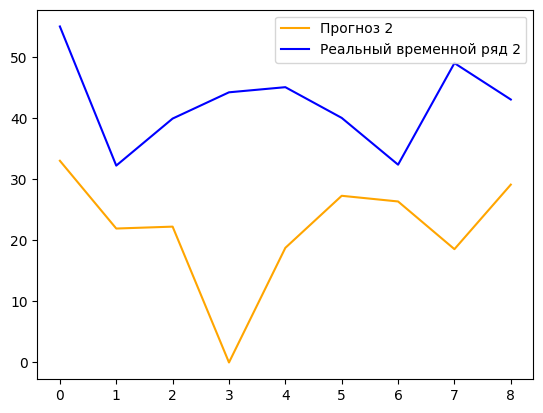

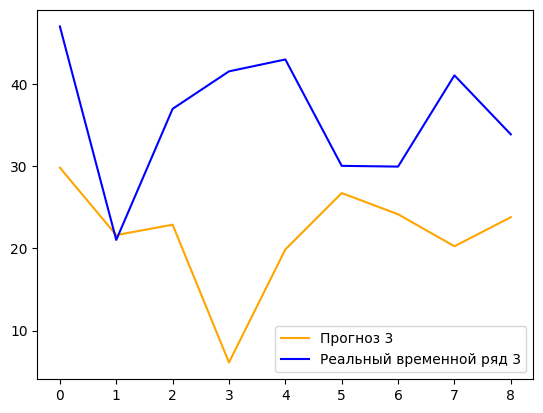

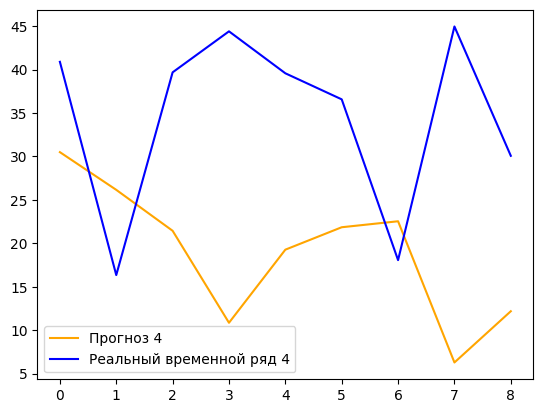

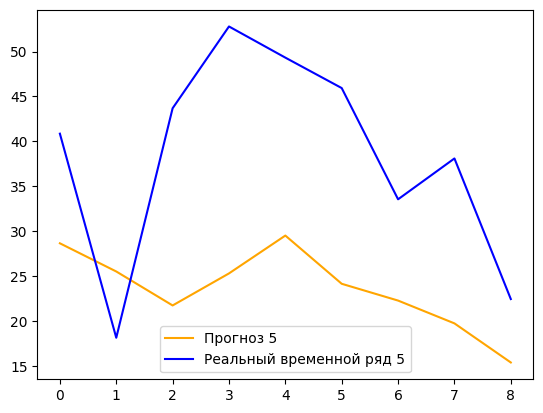

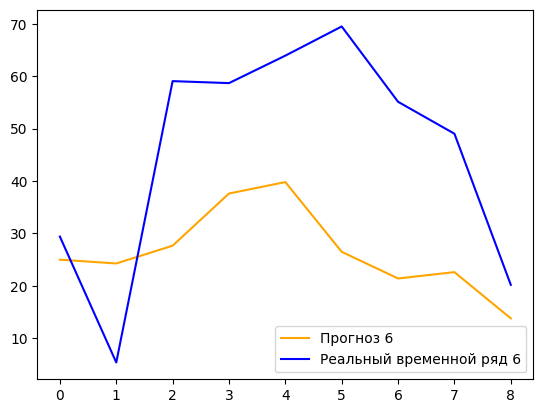

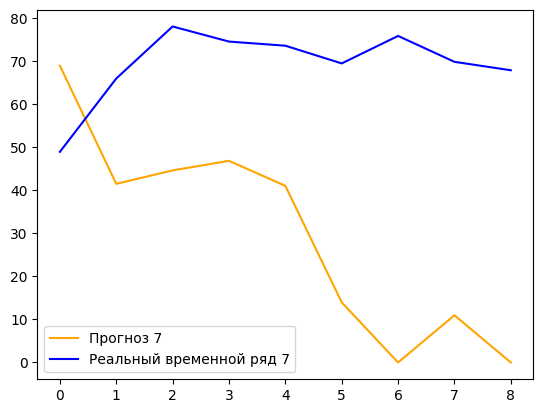

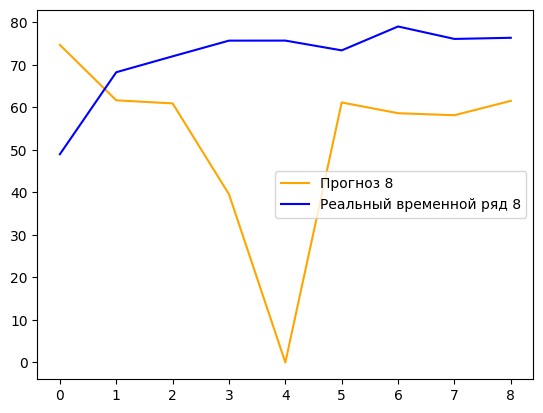

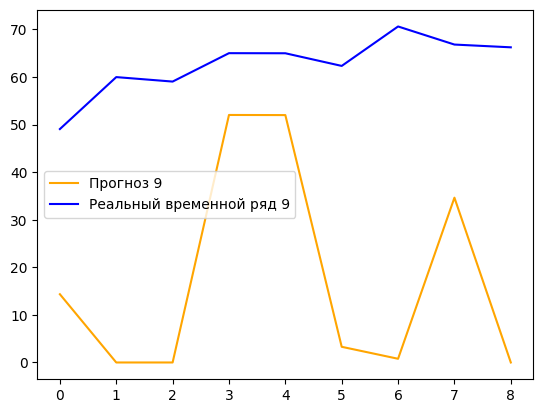

In [68]:
start_point = split_point + L - 1

for i in range(num_of_series):
    plt.plot(forecasted_ts_x_3[i], label=f'Прогноз {i}', color='orange')
    plt.plot(df.iloc[start_point:, i].values, label=f"Реальный временной ряд {i}", color='b')
    plt.legend()
    plt.show()